## Population

### Set-up

In [1]:
# Load libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, udf, stddev
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Start session
spark = SparkSession\
        .builder\
        .config("spark.driver.memory", "4g")\
        .config("spark.executor.memory", "4g")\
        .getOrCreate()

23/06/08 16:12:00 WARN Utils: Your hostname, Shaolongs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.167 instead (on interface en0)
23/06/08 16:12:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/08 16:12:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read data
path = "/Users/shaolongxue/Documents/MSBA/3_Spring_Quarter/BAX423_Big_Data_Analytics/Final Project/Data/US_Traffic_v02.csv"
data = spark.read.format('csv').option('header', 'true').load(path)

In [4]:
# Select relevant features
cols_to_remove = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Description", 
                  "Number", "Street", "Country", "Timezone", "Airport_Code", "Zipcode", 
                  "Weather_Timestamp", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", 
                  "Astronomical_Twilight", "Weather_Condition", "Wind_Direction"]

df = data.select([col for col in data.columns if col not in cols_to_remove])

df = df.na.drop()

# Cast numeric columns to appropriate types
double_columns = ["Distance(mi)", "Temperature(F)", "Wind_Chill(F)", 
                   "Humidity(%)", "Pressure(in)", "Visibility(mi)", 
                   "Wind_Speed(mph)", "Precipitation(in)", "Duration"]

integer_columns = ["Population", "Start_Year", "Start_Month"]

for column in double_columns:
    df = df.withColumn(column, col(column).cast("double"))

for column in integer_columns:
    df = df.withColumn(column, col(column).cast("integer"))

# Remove one outlier row wither Side is "N"
df = df.where(df.Side != 'N')
# Remove outliers where duration is larger than 7 days
df = df.where(df.Duration <= 168)

# Encode binary categorical columns
binary_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

for column in binary_columns:
    df = df.withColumn(column, when(col(column) == "true", 1).otherwise(0))

df = df.withColumn("Side", when(col("Side") == "L", 1).otherwise(0))

# Convert values in Start_TOD_Category column [Necessary for SMOTE]
df = df.withColumn("Start_TOD_Category",
                    when(df["Start_TOD_Category"] == "Midnight", "1")
                   .when(df["Start_TOD_Category"] == "Early Morning", "2")
                   .when(df["Start_TOD_Category"] == "Late Morning", "3")
                   .when(df["Start_TOD_Category"] == "Early Afternoon", "4")
                   .when(df["Start_TOD_Category"] == "Late Afternoon", "5")
                   .when(df["Start_TOD_Category"] == "Evening", "6"))

# First convert the categories from 'string' to 'index'
indexer = StringIndexer(inputCol="Start_TOD_Category", outputCol="Start_TOD_Category_index")
df = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol="Start_Weekday", outputCol="Start_Weekday_index")
df = indexer.fit(df).transform(df)

# Then one-hot encode these indices
encoder = OneHotEncoder(inputCols=["Start_TOD_Category_index", "Start_Weekday_index"],
                        outputCols=["Start_TOD_Category_vec", "Start_Weekday_vec"])
model = encoder.fit(df)
df = model.transform(df)

23/06/08 16:12:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### EDA

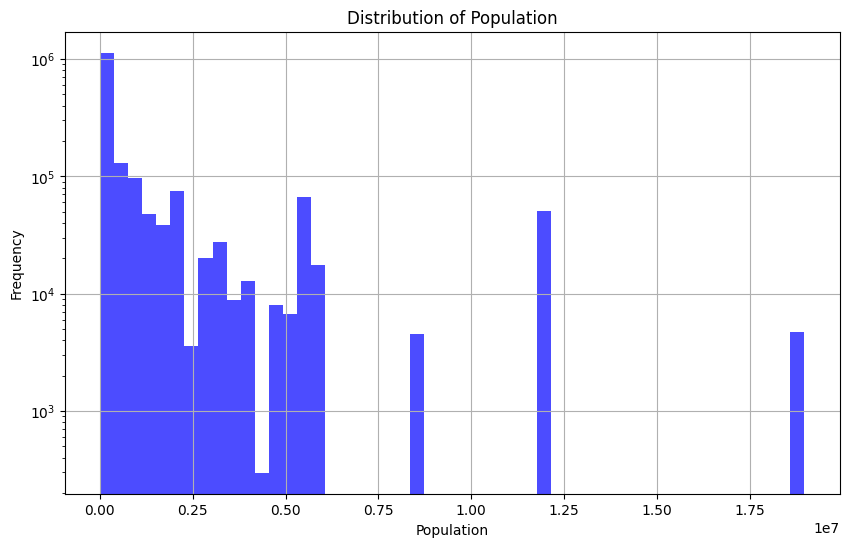

In [6]:
# First, convert the precipitation data to a list in your local environment
population_data = df.select('Population').dropna().rdd.flatMap(lambda x: x).collect()

# Now plot the data using matplotlib
plt.figure(figsize=(10,6))
plt.hist(population_data, bins=50, color='blue', alpha=0.7)
plt.yscale('log', nonpositive='clip') # This line sets the y-axis to a logarithmic scale
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
# Calculate summary stats
pop_median = df.stat.approxQuantile('Population', [0.5], 0)[0]
pop_65 = df.stat.approxQuantile('Population', [0.65], 0)[0]
pop_75 = df.stat.approxQuantile('Population', [0.75], 0)[0]
pop_85 = df.stat.approxQuantile('Population', [0.85], 0)[0]
pop_95 = df.stat.approxQuantile('Population', [0.95], 0)[0]
pop_mean = df.agg(F.avg('Population')).first()[0]
pop_sd = df.agg(stddev("Population")).collect()[0][0]
print("Population median = ", pop_median)
print("Population 65th percentile = ", pop_65)
print("Population 75th percentile = ", pop_75)
print("Population 85th percentile = ", pop_85)
print("Population 95th percentile = ", pop_95)
print("Population mean = ", round(pop_mean, 3))
print("Population standard dev = ", round(pop_sd, 3))

Precipitation median =  105087.0
Precipitation 65th percentile =  399929.0
Precipitation 75th percentile =  1062018.0
Precipitation 85th percentile =  1927699.0
Precipitation 95th percentile =  5668165.0
Precipitation mean =  1176674.037
Precipitation standard dev =  2575865.468


In [9]:
# Calculate summary statistics of target variables
sev_mean = df.agg(F.avg("Severity")).first()[0]
print("Mean of Severity =", sev_mean)

dur_mean = df.agg(F.avg("Duration")).first()[0]
dur_median = df.stat.approxQuantile("Duration", [0.5], 0)[0]
print("Mean of Duration =", dur_mean)
print("Median of Duration =", dur_median)

dis_mean = df.agg(F.avg("Distance(mi)")).first()[0]
dis_median = df.stat.approxQuantile("Distance(mi)", [0.5], 0)[0]
print("Mean of Distance =", dis_mean)
print("Median of Distance =", dis_median)

Mean of Severity = 2.074925982620811


Mean of Duration = 2.5940729781570435
Median of Duration = 1.7


Mean of Distance = 0.6984340712537626
Median of Distance = 0.21100000000000002


### Severity

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [29]:
cutoff = [pop_median, pop_mean, pop_65, pop_75, pop_85, pop_95]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Precipitation(in)', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Severity", "City Size"] + covariates

In [ ]:
from sklearn.neighbors import NearestNeighbors

for i in cutoff:
    print("\n")
    print("Cut-off =", i)
    # Create treatment variables
    df = df.withColumn('City Size', when(df['Population'] >= i, 1).otherwise(0))

    # Check balance
    print("Treatment & Control Group Balance:")
    print(df.groupBy("City Size").count().show())

    df_ps = df.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='City Size', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Severity', 'City Size', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='City Size', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['City Size'] == 1]
    df_control = ps_pd[ps_pd['City Size'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

    matched_pairs['Severity_treatment'] = matched_pairs['Severity_treatment'].astype(float)
    matched_pairs['Severity_control'] = matched_pairs['Severity_control'].astype(float)

    matched_pairs['treatment_effect'] = matched_pairs['Severity_treatment'] - matched_pairs['Severity_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))

#### Summary

The average treatment effect of population size on accident severity (measured on a scale of 1 to 4, with 4 being the most severe) is 0.0146 unit. 

median: AUC = 0.632, ATE = -0.0473

65th: AUC = 0.63, ATE = -0.0308

75th: AUC = , ATE = -0.0227

mean: AUC = 0.636, ATE = -0.0054

85th: AUC = 0.649, ATE = 0.0121 

95th: AUC = 0.666, ATE = 0.0146

### Duration

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [30]:
cutoff = [pop_median, pop_mean, pop_65, pop_75, pop_85, pop_95]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Precipitation(in)', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Duration", "City Size"] + covariates

In [31]:
from sklearn.neighbors import NearestNeighbors

for i in cutoff:
    print("\n")
    print("Cut-off =", i)
    # Create treatment variables
    df = df.withColumn('City Size', when(df['Population'] >= i, 1).otherwise(0))

    # Check balance
    print("Treatment & Control Group Balance:")
    print(df.groupBy("City Size").count().show())

    df_ps = df.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='City Size', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Duration', 'City Size', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='City Size', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['City Size'] == 1]
    df_control = ps_pd[ps_pd['City Size'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

    matched_pairs['treatment_effect'] = matched_pairs['Duration_treatment'] - matched_pairs['Duration_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Cut-off = 105087.0
Treatment & Control Group Balance:


+---------+------+
|City Size| count|
+---------+------+
|        1|872815|
|        0|872721|
+---------+------+

None


AUC = 0.633


ATE = -0.0195


Cut-off = 1176674.0367743776
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 393126|
|        0|1352410|
+---------+-------+

None


AUC = 0.635


ATE = 0.0692


Cut-off = 399929.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 611034|
|        0|1134502|
+---------+-------+

None


AUC = 0.631


ATE = 0.0156


Cut-off = 1062018.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 437042|
|        0|1308494|
+---------+-------+

None


AUC = 0.627


ATE = 0.0556


Cut-off = 1927699.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 286287|
|        0|1459249|
+---------+-------+

None


AUC = 0.649


ATE = 0.1988


Cut-off = 5668165.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 110293|
|        0|1635243|
+---------+-------+

None


AUC = 0.67


ATE = 0.4093


#### Summary

The average treatment effect of population size on accident duration (measured in hours) is 0.41 hour. 

### Distance

#### Address imbalance, calculate PS, model eval, matching, calculate ATE

In [6]:
cutoff = [pop_median, pop_mean, pop_65, pop_75, pop_85, pop_95]
covariates = ['Side', 'Wind_Chill(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 
              'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 
              'Traffic_Signal', 'Turning_Loop', 'Precipitation(in)', 'Start_Weekday_vec', 'Start_TOD_Category_vec']
selected_columns = ["Distance(mi)", "City Size"] + covariates

In [7]:
from sklearn.neighbors import NearestNeighbors

for i in cutoff:
    print("\n")
    print("Cut-off =", i)
    # Create treatment variables
    df = df.withColumn('City Size', when(df['Population'] >= i, 1).otherwise(0))

    # Check balance
    print("Treatment & Control Group Balance:")
    print(df.groupBy("City Size").count().show())

    df_ps = df.select(selected_columns)

    # Define the covariates
    assembler = VectorAssembler(inputCols=covariates, outputCol="features")
    train_data, test_data = df_ps.randomSplit([0.8, 0.2], seed=1)
    lr = LogisticRegression(featuresCol='features', labelCol='City Size', maxIter=10)
    pipeline = Pipeline(stages=[assembler, lr])
    model = pipeline.fit(train_data)

    # Predict and add the propensity scores to the DataFrame
    ps = model.transform(test_data).select('Distance(mi)', 'City Size', 'features', 'probability')

    # Extract the probability of treatment (i.e., the propensity score)
    extract_prob = udf(lambda x: float(x[1]), FloatType())
    ps = ps.withColumn("propensity_score", extract_prob('probability'))

    # Evaluate model performance on the test data
    auc = BinaryClassificationEvaluator(labelCol='City Size', rawPredictionCol='probability', metricName='areaUnderROC')
    AUC = round(auc.evaluate(ps), 3)
    print('AUC =', AUC)

    ps_pd = ps.toPandas()

    # Create two dataframes for treatment and control groups
    df_treatment = ps_pd[ps_pd['City Size'] == 1]
    df_control = ps_pd[ps_pd['City Size'] == 0]

    # Fit nearest neighbors model to control group
    nbrs = NearestNeighbors(n_neighbors=1).fit(df_control[['propensity_score']])

    # Find nearest neighbors in control group for each treatment case
    distances, indices = nbrs.kneighbors(df_treatment[['propensity_score']])

    # Create dataframe of distances and indices
    matches = pd.DataFrame({'distance': distances.flatten(), 'control_index': indices.flatten(),
                            'treatment_index': df_treatment.index})

    # Merge data from treatment and control cases into the matches dataframe
    matched_pairs = matches.merge(df_treatment, left_on='treatment_index', right_index=True) \
        .merge(df_control, left_on='control_index', right_index=True, suffixes=('_treatment', '_control'))

    matched_pairs['treatment_effect'] = matched_pairs['Distance(mi)_treatment'] - matched_pairs['Distance(mi)_control']
    average_treatment_effect = matched_pairs['treatment_effect'].mean()
    print("ATE =", round(average_treatment_effect, 4))



Cut-off = 105087.0
Treatment & Control Group Balance:


+---------+------+
|City Size| count|
+---------+------+
|        1|872815|
|        0|872721|
+---------+------+

None


23/06/08 16:13:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/06/08 16:13:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


AUC = 0.632


ATE = -0.1852


Cut-off = 1176674.0367743776
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 393126|
|        0|1352410|
+---------+-------+

None


AUC = 0.636


ATE = -0.2034


Cut-off = 399929.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 611034|
|        0|1134502|
+---------+-------+

None


AUC = 0.63


ATE = -0.2375


Cut-off = 1062018.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 437042|
|        0|1308494|
+---------+-------+

None


AUC = 0.628


ATE = -0.224


Cut-off = 1927699.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 286287|
|        0|1459249|
+---------+-------+

None


AUC = 0.649


ATE = -0.1789


Cut-off = 5668165.0
Treatment & Control Group Balance:


+---------+-------+
|City Size|  count|
+---------+-------+
|        1| 110293|
|        0|1635243|
+---------+-------+

None


AUC = 0.667


ATE = -0.1284


#### Summary

The average treatment effect of population size on accident distance impacted is -0.24 miles.

More pop, more emergency response personnel.
Or more likely to occure in city streets, where distances are shorter and have more alternative routes to disperse traffic.